In [14]:
import os
import re
import pandas as pd
import json

folder_path = "/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Additional_Results/full_size/evaluation"

dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r") as file:
            records = [json.loads(line) for line in file if line.strip()]
            df = pd.DataFrame(records)
            if "Llama-3.2-1B-Instruct" in filename:
                model_name = "Llama-3.2-1B-Instruct"
            elif "Meta-Llama-3-8B-Instruct" in filename:
                model_name = "Meta-Llama-3-8B-Instruct"
            elif "Mixtral-8x7B-Instruct-v0.1" in filename:
                model_name = "Mixtral-8x7B-Instruct-v0.1"
            else:
                model_name = "Unknown"
                continue
            df["model_name"] = f"{model_name}_full_precision"
            if "accuracy" in df.columns:
                df["accuracy"] = df["accuracy"].astype(float)
            else:
                df["accuracy"] = df.apply(
                    lambda row: (
                        row[f"{row['category']}_accuracy"]
                        if f"{row['category']}_accuracy" in df.columns
                        else None
                    ),
                    axis=1,
                )
            df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
            df["temperature"] = df["temperature"].apply(
                lambda x: round(x, 2) if pd.notna(x) else x
            )
            columns_to_keep = ["model_name", "temperature", "category", "accuracy"]
            df = df[columns_to_keep]
            dfs.append(df)


folder_path = "/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Additional_Results/extent_temperature_with_complementary_4bits/evaluation"

for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r") as file:
            records = [json.loads(line) for line in file if line.strip()]
            df = pd.DataFrame(records)
            if "Llama-3.2-1B-Instruct" in filename:
                model_name = "Llama-3.2-1B-Instruct"
            elif "Meta-Llama-3-8B-Instruct" in filename:
                model_name = "Meta-Llama-3-8B-Instruct"
            elif "Mixtral-8x7B-Instruct-v0.1" in filename:
                model_name = "Mixtral-8x7B-Instruct-v0.1"
            else:
                model_name = "Unknown"
                continue
            df["model_name"] = f"{model_name}_4_bits_quantized"
            if "accuracy" in df.columns:
                df["accuracy"] = df["accuracy"].astype(float)
            else:
                df["accuracy"] = df.apply(
                    lambda row: (
                        row[f"{row['category']}_accuracy"]
                        if f"{row['category']}_accuracy" in df.columns
                        else None
                    ),
                    axis=1,
                )
            df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
            df["temperature"] = df["temperature"].apply(
                lambda x: round(x, 2) if pd.notna(x) else x
            )
            columns_to_keep = ["model_name", "temperature", "category", "accuracy"]
            df = df[columns_to_keep]
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
# df = df.dropna(subset=["accuracy"])

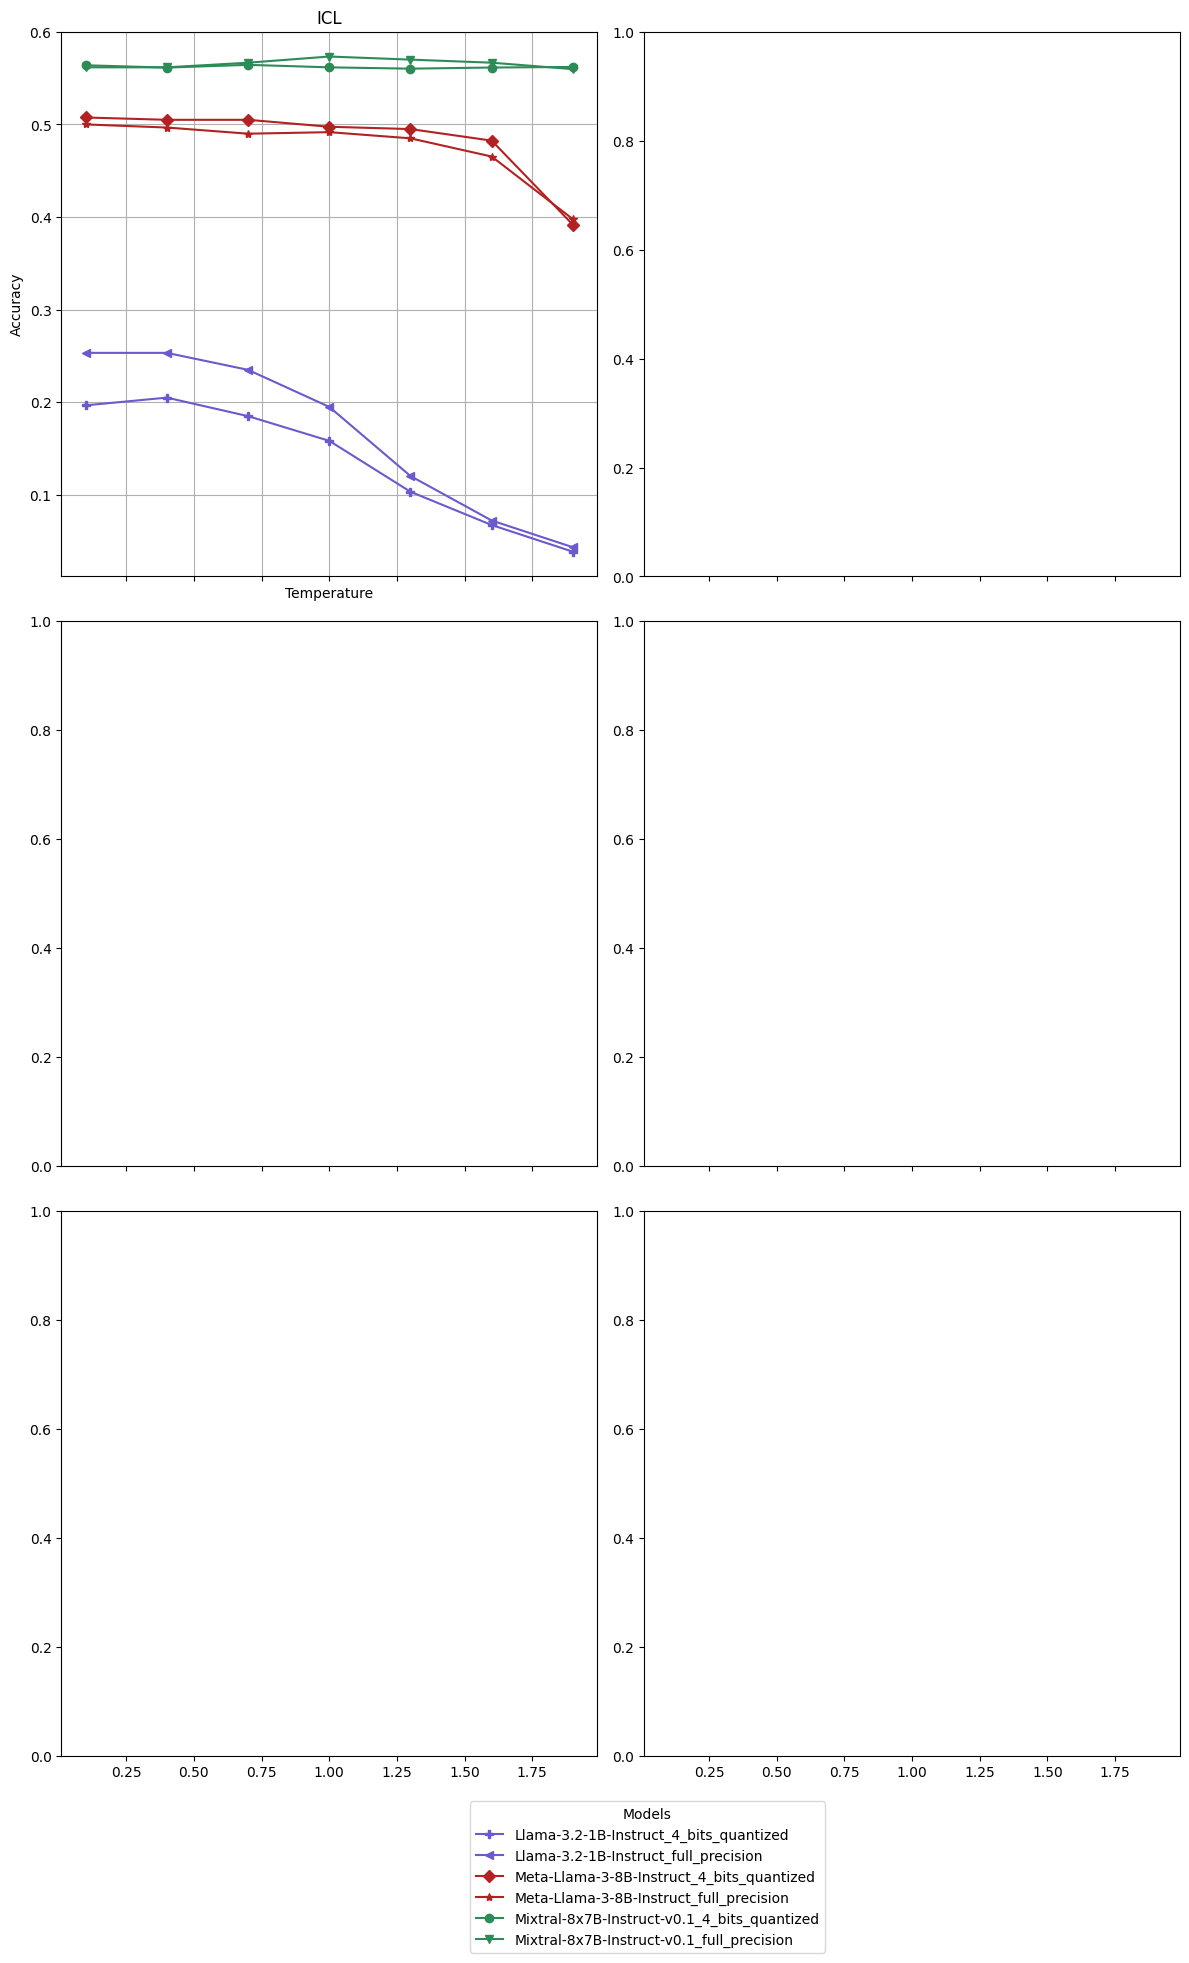

In [76]:
import matplotlib.pyplot as plt

grouped = (
    df.groupby(["category", "model_name", "temperature"]).accuracy.mean().reset_index()
)

color_map = {
    "Meta-Llama-3-8B-Instruct_4_bits_quantized": "firebrick",  # closer to dark red
    "Mixtral-8x7B-Instruct-v0.1_4_bits_quantized": "seagreen",   # closer to mediumseagreen
    "Llama-3.2-1B-Instruct_4_bits_quantized": "slateblue",      # closer to mediumpurple
    "Meta-Llama-3-8B-Instruct_full_precision": "firebrick",      # same as 4-bit quantized
    "Mixtral-8x7B-Instruct-v0.1_full_precision": "seagreen",     # same as 4-bit quantized
    "Llama-3.2-1B-Instruct_full_precision": "slateblue",         # same as 4-bit quantized
}

marker_map = {
    "Meta-Llama-3-8B-Instruct_4_bits_quantized": "D",  # diamond
    "Mixtral-8x7B-Instruct-v0.1_4_bits_quantized": "o", # inverted triangle
    "Llama-3.2-1B-Instruct_4_bits_quantized": "P",    # left-pointing triangle
    "Meta-Llama-3-8B-Instruct_full_precision": "*",    # diamond
    "Mixtral-8x7B-Instruct-v0.1_full_precision": "v",   # inverted triangle
    "Llama-3.2-1B-Instruct_full_precision": "<",       # left-pointing triangle
}



categories = grouped["category"].unique()
categories = ["ICL"]
data_dict = {}

# Create a grid for subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18), sharex=True)
axes = axes.flatten()

for i, category in enumerate(categories):
    ax = axes[i]
    subset = grouped[grouped["category"] == category]
    for model_name in subset["model_name"].unique():
        model_data = subset[subset["model_name"] == model_name]
        data_dict[model_name] = model_data["accuracy"].to_list()
        ax.plot(
            model_data["temperature"],
            model_data["accuracy"],
            marker=marker_map[model_name],
            color=color_map[model_name],
            label=model_name,
        )
    ax.set_title(f"{category}")
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Accuracy")
    # ax.legend(title="Model Name", loc="upper left", bbox_to_anchor=(1, 1))
    ax.grid(True)
    
handles = []
labels = []

for model_name in subset["model_name"].unique():
    handle, = ax.plot([], [], label=model_name, marker=marker_map[model_name], color=color_map[model_name])
    handles.append(handle)
    labels.append(f"{model_name}")

fig.legend(
    handles=handles,  # small models first
    labels=labels,  # corresponding labels
    loc="upper left",
    bbox_to_anchor=(0.39, 0.00),  # Position the legend below the plot, left-aligned
    ncol=1,  # 1 column for small models
    title="Models",
    columnspacing=1.5,
    
)

fig.tight_layout()
plt.show()

In [77]:
import numpy as np

def ncc(f, g):
    f = np.array(f)
    g = np.array(g)
    
    mu_f = np.mean(f)
    mu_g = np.mean(g)
    
    cov_fg = np.mean((f - mu_f) * (g - mu_g))
    
    sigma_f = np.std(f)
    sigma_g = np.std(g)
    
    ncc_value = cov_fg / (sigma_f * sigma_g)
    
    return ncc_value

from scipy.stats import pearsonr, spearmanr

# 计算皮尔逊相关系数
def calculate_pearson_corr(data1, data2):
    return pearsonr(data1, data2)[0]

# 计算斯皮尔曼等级相关系数
def calculate_spearman_corr(data1, data2):
    return spearmanr(data1, data2)[0]


def find_max_index(data_list):
    max_index = data_list.index(max(data_list))
    return max_index

# Printing the index with the maximum value for each entry in data_dict
for model_name in data_dict:
    max_index = find_max_index(data_dict[model_name])
    print(f"The index with the maximum value in {model_name} is: {0.1+ 0.3* max_index}")

# 示例计算皮尔逊相关系数
pearson_result = calculate_pearson_corr(data_dict["Llama-3.2-1B-Instruct_4_bits_quantized"], data_dict["Llama-3.2-1B-Instruct_full_precision"])
print(f"Pearson correlation between Llama-3.2-1B-Instruct_4_bits_quantized and Llama-3.2-1B-Instruct_full_precision: {pearson_result:.4f}")

pearson_result = calculate_pearson_corr(data_dict["Meta-Llama-3-8B-Instruct_4_bits_quantized"], data_dict["Meta-Llama-3-8B-Instruct_full_precision"])
print(f"Pearson correlation between Meta-Llama-3-8B-Instruct_4_bits_quantized and Meta-Llama-3-8B-Instruct_full_precision: {pearson_result:.4f}")

pearson_result = calculate_pearson_corr(data_dict["Mixtral-8x7B-Instruct-v0.1_4_bits_quantized"], data_dict["Mixtral-8x7B-Instruct-v0.1_full_precision"])
print(f"Pearson correlation between Mixtral-8x7B-Instruct-v0.1_4_bits_quantized and Mixtral-8x7B-Instruct-v0.1_full_precision: {pearson_result:.4f}")


spearman_result = calculate_spearman_corr(data_dict["Llama-3.2-1B-Instruct_4_bits_quantized"], data_dict["Llama-3.2-1B-Instruct_full_precision"])
print(f"Spearman correlation between Llama-3.2-1B-Instruct_4_bits_quantized and Llama-3.2-1B-Instruct_full_precision: {spearman_result:.4f}")

spearman_result = calculate_spearman_corr(data_dict["Meta-Llama-3-8B-Instruct_4_bits_quantized"], data_dict["Meta-Llama-3-8B-Instruct_full_precision"])
print(f"Spearman correlation between Meta-Llama-3-8B-Instruct_4_bits_quantized and Meta-Llama-3-8B-Instruct_full_precision: {spearman_result:.4f}")

spearman_result = calculate_spearman_corr(data_dict["Mixtral-8x7B-Instruct-v0.1_4_bits_quantized"], data_dict["Mixtral-8x7B-Instruct-v0.1_full_precision"])
print(f"Spearman correlation between Mixtral-8x7B-Instruct-v0.1_4_bits_quantized and Mixtral-8x7B-Instruct-v0.1_full_precision: {spearman_result:.4f}")


The index with the maximum value in Llama-3.2-1B-Instruct_4_bits_quantized is: 0.4
The index with the maximum value in Llama-3.2-1B-Instruct_full_precision is: 0.1
The index with the maximum value in Meta-Llama-3-8B-Instruct_4_bits_quantized is: 0.1
The index with the maximum value in Meta-Llama-3-8B-Instruct_full_precision is: 0.1
The index with the maximum value in Mixtral-8x7B-Instruct-v0.1_4_bits_quantized is: 0.7
The index with the maximum value in Mixtral-8x7B-Instruct-v0.1_full_precision is: 0.9999999999999999
Pearson correlation between Llama-3.2-1B-Instruct_4_bits_quantized and Llama-3.2-1B-Instruct_full_precision: 0.9986
Pearson correlation between Meta-Llama-3-8B-Instruct_4_bits_quantized and Meta-Llama-3-8B-Instruct_full_precision: 0.9908
Pearson correlation between Mixtral-8x7B-Instruct-v0.1_4_bits_quantized and Mixtral-8x7B-Instruct-v0.1_full_precision: -0.3217
Spearman correlation between Llama-3.2-1B-Instruct_4_bits_quantized and Llama-3.2-1B-Instruct_full_precision: 0.

In [39]:
data_dict["Mixtral-8x7B-Instruct-v0.1_full_precision"]

[0.8625304136253041,
 0.8613138686131386,
 0.8600973236009732,
 0.8673965936739659,
 0.8698296836982968,
 0.8734793187347932,
 0.8722627737226277]

In [46]:
data_dict["Mixtral-8x7B-Instruct-v0.1_4_bits_quantized"]

[0.8467153284671532,
 0.8467153284671532,
 0.8485401459854015,
 0.8448905109489051,
 0.8485401459854015,
 0.8448905109489051,
 0.8503649635036497]

In [99]:
import pandas as pd

# CR
import os

category = "CR"
folder_path = f"/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Results/{category}"
evaluated_files = [f for f in os.listdir(folder_path) if f.endswith("evaluated.csv")]
dfs = []


def str_to_bool(s):
    return s == "[True]"


def top1_accuracy_per_group(
    df, pctid_col="PCTID", temp_col="Temperature", pred_col="bool_eval"
):
    def top1_accuracy(group):
        correct = (group[pred_col]).sum()
        total = len(group)
        return correct / total

    accuracy_df = (
        df.groupby([pctid_col, temp_col, "model", "initial_prompt"])
        .apply(top1_accuracy)
        .reset_index(name="top1_accuracy")
    )
    return accuracy_df


for file in evaluated_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df["bool_eval"] = df["eval"].apply(str_to_bool)
    df = top1_accuracy_per_group(df)
    df["accuracy"] = df["top1_accuracy"]
    df["category"] = "CR"
    df["temperature"] = df["Temperature"]
    df["pure_response"] = df["PCTID"]
    columns_to_keep = [
        "initial_prompt",
        "pure_response",
        "model",
        "temperature",
        "accuracy",
        "category",
    ]
    df = df[columns_to_keep]
    model_name = df["model"].unique()[0]
    df.to_json(
        os.path.join(
            folder_path,
            f"evaluated_GPT_vllm_exp_dataset_csv_{model_name}_4bit_{category}.jsonl",
        ),
        orient="records",
        lines=True,
    )

/tmp/ipykernel_3328577/2518991799.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(top1_accuracy)
/tmp/ipykernel_3328577/2518991799.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(top1_accuracy)
/tmp/ipykernel_3328577/2518991799.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

In [6]:
import pandas as pd

# CT
category = "CT"
folder_path = f"/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Results/{category}"
evaluated_files = [f for f in os.listdir(folder_path) if f.endswith("evaluated.csv")]
dfs = []

for file in evaluated_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df["accuracy"] = df["OpenAI_response"].apply(
        lambda x: 1 if x.startswith("Yes") else (0 if x.startswith("No") else None)
    )
    df["category"] = "CT"
    df["temperature"] = df["Temperature"]
    df = (
        df.groupby(
            [
                "formatted_prompt",
                "pure_response",
                "model",
                "temperature",
                "category",
                "generated_response",
            ]
        )["accuracy"]
        .mean()
        .reset_index()
    )
    df["initial_prompt"] = df["formatted_prompt"]
    columns_to_keep = [
        "initial_prompt",
        "pure_response",
        "model",
        "temperature",
        "accuracy",
        "category",
    ]
    df = df[columns_to_keep]
    model_name = df["model"].unique()[0]
    df.to_json(
        os.path.join(
            folder_path,
            f"evaluated_GPT_vllm_exp_dataset_csv_{model_name}_4bit_{category}.jsonl",
        ),
        orient="records",
        lines=True,
    )

In [7]:
import pandas as pd
import pandas as pd

# ICL
category = "ICL"
folder_path = f"/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Results/{category}"
evaluated_files = [f for f in os.listdir(folder_path) if f.endswith("evaluated.csv")]
dfs = []

for file in evaluated_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df = df[df["dataset"] == "trec_e"]
    df["accuracy"] = df["classification_score"]
    df["category"] = "ICL"
    columns_to_keep = [
        "initial_prompt",
        "pure_response",
        "model",
        "temperature",
        "accuracy",
        "category",
    ]
    df = df[columns_to_keep]
    model_name = df["model"].unique()[0]
    df.to_json(
        os.path.join(
            folder_path,
            f"evaluated_GPT_vllm_exp_dataset_csv_{model_name}_4bit_{category}.jsonl",
        ),
        orient="records",
        lines=True,
    )

In [27]:
import pandas as pd

category = "IF"
folder_path = f"/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Results/{category}"
evaluated_files = [f for f in os.listdir(folder_path) if f.endswith("evaluated.csv")]
dfs = []


def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


for file in evaluated_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df[["true_count", "false_count"]] = (
        df["eval"].apply(count_true_false).apply(pd.Series)
    )
    df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])
    df["accuracy"] = df["DRFR"]
    df["category"] = "IF"

    columns_to_keep = [
        "initial_prompt",
        "pure_response",
        "model",
        "temperature",
        "accuracy",
        "category",
    ]
    df = df[columns_to_keep]
    model_name = df["model"].unique()[0]
    df = df.dropna(subset=["accuracy"])
    df.to_json(
        os.path.join(
            folder_path,
            f"evaluated_GPT_vllm_exp_dataset_csv_{model_name}_4bit_{category}.jsonl",
        ),
        orient="records",
        lines=True,
    )

In [34]:
import pandas as pd
import os

category = "MT"
folder_path = f"/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Results/{category}"
evaluated_files = [f for f in os.listdir(folder_path) if f.endswith("evaluated.csv")]
dfs = []

for file in evaluated_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df["accuracy"] = df["spbleu"]
    print(df["spbleu"].isna().any())
    df["category"] = "MT"
    columns_to_keep = [
        "initial_prompt",
        "pure_response",
        "model",
        "temperature",
        "accuracy",
        "category",
    ]
    df = df[columns_to_keep]
    model_name = df["model"].unique()[0]
    df = df.dropna(subset=["accuracy"])
    df.to_json(
        os.path.join(
            folder_path,
            f"evaluated_GPT_vllm_exp_dataset_csv_{model_name}_4bit_{category}.jsonl",
        ),
        orient="records",
        lines=True,
    )

True
False
False
False
False
False
False


In [10]:
import pandas as pd

category = "SUMM"
folder_path = f"/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Results/{category}"
evaluated_files = [f for f in os.listdir(folder_path) if f.endswith("evaluated.csv")]
dfs = []

for file in evaluated_files:
    df = pd.read_csv(os.path.join(folder_path, file))

    df["accuracy"] = df["rouge_l_fmeasure"]
    df["category"] = "SUMM"
    columns_to_keep = [
        "initial_prompt",
        "pure_response",
        "model",
        "temperature",
        "accuracy",
        "category",
    ]
    df = df[columns_to_keep]
    model_name = df["model"].unique()[0]
    df.to_json(
        os.path.join(
            folder_path,
            f"evaluated_GPT_vllm_exp_dataset_csv_{model_name}_4bit_{category}.jsonl",
        ),
        orient="records",
        lines=True,
    )